# Lab 01 - Exit the dungeon!

In this first lab, we will create by hand our first Reinforcement Learning environment.
A lot of agents will be harmed in the process of solving the lab.

## The environment

The environment is a NxN array of integers. 
Each cell of this environment can have the following values:
- 0 : empty cell
- 1 : obstacle, non-traversable
- 2 : lava
- 3 : exit

All border cells are obstacles.
Upon initialization, the environment has:
- N/2 obstacles placed randomly in the maze.
- N/2 lava cells placed randomly in the cell.

## The game

The agent starts in a random empty cell, and has to reach the exit.
The exit is randomly positioned in an other empty cell.

At each timestep:
- the agent decides on an action (move up, left, right or down)
- the action is sent to the environment
- the environment sends back observations, rewards and a boolean that indicates whether the environment terminated.

The environment terminates if the agent reaches the exit, or if the environement reaches a time limit of N^2 timesteps.

## Observations

The agent receives a dictionary of observations:
- target: relative coordinates of the exit 
- proximity: a 3x3 array that encodes for the value of the cells around the agent.

## Rewards

When acting, an agent receives a reward depending on the cell it ends up on:
- if the agent moves towards an obstacle, it gets a reward of -5 and stays at its original position
- if the agent is on a lava cell after its action, it receives a reward of -20
- at each timestep, the agent receives an additional reward of -1
- when the agent reaches the goal, it receives a reward of N**2


In [998]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from random import choice
from numpy import mean, var
import random
%matplotlib inline
plt.style.use('ggplot')

# Part 1 - Defining the environment.

We will define the environment as a class.
We are providing pseudo code which is incomplete and probably not completely error-free.

You have to fill the blanks.
We advise you to look at the pseudo-code for Part 2 and 3 to have an idea of how things work together.

In order to make sure that your environment runs as intended, you will create a display function.

In [1021]:
class Dungeon:
    
    def __init__(self, N):
        
        # Numpy array that holds the information about the environment
        self.dungeon = self.make_dungeon(N)
        
        # position of the agent and exit will be decided by resetting the environment.
        self.position_agent = None
        self.position_exit = None
        
        self.time_elapsed = 0
        self.time_limit = N**2
        
        self.reward = 0
        self.done = False
        
        # Allows me to call N elsewhere
        self.N = N
   
    def make_dungeon(self, N):
        # Create empty array defining dungeon area
        dung_array = np.zeros((N,N))
        
        # Making dungeon borders = 1
        dung_array[:,[0,-1]] = dung_array[[0,-1]] = 1
        
        # Random (x, y) coordinates for obstacles
        obs_idx_x = np.random.randint(1, dung_array.shape[0]-1, N)
        obs_idx_y = np.random.randint(1, dung_array.shape[1]-1, N)

        # Assigning obstacles
        dung_array[obs_idx_x[0:int(N/2)], obs_idx_y[0:int(N/2)]] = 1
        # Assigning lava
        dung_array[obs_idx_x[int(N/2):N], obs_idx_y[int(N/2):N]] = 2
        
        return dung_array
    
    def agent_and_exit_starting_location(self, dungeon):
        empty_cells = np.argwhere(dungeon == 0)
        
        # Selecting a random one of those empty cells, then choosing similar for exit, not equal to agent location
        empty_rand_idx_agent = np.random.randint(0, len(empty_cells)-1, 1)
        empty_rand_idx_exit = choice([i for i in range(0, len(empty_cells)-1) if i != empty_rand_idx_agent[0]])

        # Returning the starting location of the agent and the exit
        agent_start = [empty_cells[empty_rand_idx_agent[0]][0], empty_cells[empty_rand_idx_agent[0]][1]]
        exit_start = [empty_cells[empty_rand_idx_exit][0], empty_cells[empty_rand_idx_exit][1]]
              
        return agent_start, exit_start
    
    def get_observations(self, agent, exit, dungeon):
        observation_dict = {}
        
        # Returning the values in the cells surrounding the agent
        three_by_three = dungeon[agent[0]-1: agent[0]+2, agent[1]-1: agent[1]+2]
        
        observation_dict['observed'] = three_by_three
        observation_dict['exit_loc'] = exit
        
        return observation_dict

    def step(self, action):
        
        # action is 'up', 'down', 'left', or 'right' 
        agent_move = action

        # modify the position of the agent
        if agent_move == 'up':
            self.position_agent[0] = self.position_agent[0]-1
        if agent_move == 'down':
            self.position_agent[0] = self.position_agent[0]+1
        if agent_move == 'left':
            self.position_agent[1] = self.position_agent[1]-1
        if agent_move == 'right':
            self.position_agent[1] = self.position_agent[1]+1
        
        # calculate total reward
        if self.dungeon[self.position_agent[0], self.position_agent[1]] == 1:
            # Removes 5 from total reward, plus 1 for the step taken 
            self.reward -= 6
            # Resets movement, back to where agent was before
            if agent_move == 'up':
                self.position_agent[0] = self.position_agent[0]+1
            elif agent_move == 'down':
                self.position_agent[0] = self.position_agent[0]-1
            elif agent_move == 'left':
                self.position_agent[1] = self.position_agent[1]+1
            elif agent_move == 'right':
                self.position_agent[1] = self.position_agent[1]-1

        elif self.dungeon[self.position_agent[0], self.position_agent[1]] == 2:
            # Removed 20 for lava, plus 1 for the step taken
            self.reward -= 21

        elif self.dungeon[self.position_agent[0], self.position_agent[1]] == 3:
            # N**2 for finding the exit, minus 1 for the step taken
            self.reward += ((self.N**2)-1)
            #print("Congratulations - You have found the exit! Your score was: %d" % self.reward)
            self.done = True

        elif self.dungeon[self.position_agent[0], self.position_agent[1]] == 0:
            # Just -1 for the step taken
            self.reward -= 1
        
        elif self.dungeon[self.position_agent[0], self.position_agent[1]] == 4:
            # Just -1 for the step taken
            self.reward -= 1
        
        # calculate observations
        
        self.observations = self.get_observations(self.position_agent, self.position_exit, self.dungeon)
        
        # update time
        self.time_elapsed += 1
        
        # verify secondary termination condition
        if self.time_elapsed == self.time_limit:
            #print("Gameover - Out of Moves. Your score was: %d" % self.reward)
            self.done = True
        
        # Mark the new position of the agent with a '4' (useful for debugging/visualizing)
        self.dungeon[self.position_agent[0], self.position_agent[1]] = 4
        
        return self.observations, self.reward, self.done
    
    def display(self):
        
        # prints the environment
        print(self.dungeon)
        
    def reset(self):
        """
        This function resets the environment to its original state (time = 0).
        Then it places the agent and exit at new random locations.
        
        It is common practice to return the observations, 
        so that the agent can decide on the first action right after the resetting of the environment.
        
        """
        # Resetting variables to zero:
        self.time_elapsed = 0
        self.time_limit = self.N**2
        self.reward = 0
        self.done = False
        
        # Make new dungeon
        self.dungeon = self.make_dungeon(self.N)
        
        # position of the agent is a numpy array
        self.position_agent, self.position_exit = self.agent_and_exit_starting_location(self.dungeon)
        
        # Mark the exit location with '3'
        self.dungeon[self.position_exit[0], self.position_exit[1]] = 3
        
        # Mark the agent location with '4'
        self.dungeon[self.position_agent[0], self.position_agent[1]] = 4
        
        # Calculate observations
        self.observations = self.get_observations(self.position_agent, self.position_exit, self.dungeon)
        
    
        return self.observations, self.time_elapsed

In [312]:
dungeon = Dungeon(10)
dungeon.reset()

print(dungeon.position_agent)
dungeon.display()

obs, reward, done = dungeon.step('right')


[3, 3]
[[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 1. 0. 1. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 4. 0. 2. 0. 0. 2. 1.]
 [1. 0. 0. 2. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 1. 0. 0. 2. 0. 1.]
 [1. 0. 0. 0. 1. 0. 0. 0. 1. 1.]
 [1. 0. 0. 0. 0. 0. 2. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0. 3. 0. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]]


# Part 2 - Defining a policy

A policy tells the agent how to act depending on its current observation and internal beliefs.

As a first simple case, we will define policy as a function that maps observations to actions.

As your agent is stupid and doesn't have any way of learning what to do, in this first lab we will write by hand the policy.
Try to come up with a strategy to terminate the game with the maximum reward.

We advise you to start with a very simple policy, then maybe try a random policy, and finally an 'intelligent' policy.


In [1039]:
def basic_policy(observation, action_lst):
    # Checks observations and then decides to get to either the 0 or 3 square within observation area
    
    possible_routes = 0
    exit_route_action = []
    possible_actions = []
    lava_action = []

    for a, b, c in zip([0, 1, 1, 2],[1, 2, 0, 1],['up', 'right', 'left', 'down']):
        # Calculates cost caused by obstacle in moving by using specified action
        cost = dungeon.observations['observed'][a][b]
        if cost == 0:
            possible_routes += 1
            possible_actions.append(c)
        if cost == 3:
            exit_route_action.append(c)
        if cost == 4:
            possible_routes += 1
            possible_actions.append(c)
        if cost == 2:
            lava_action.append(c)
        
    # checks if exit route list is empty, if not then chooses that route
    if not exit_route_action:
        if len(possible_actions)>0:
            # Chooses viable option randomly to avoid going back and forth
            dir_choice = np.random.randint(0, possible_routes, 1)
            action = possible_actions[int(dir_choice)]
        else:
            dir_choice = np.random.randint(0, len(lava_action), 1)
            action = lava_action[int(dir_choice)]
    else:
        action = exit_route_action[0]
    
    return action


def random_policy(observation, action_lst):
    possible_actions = ['up', 'right', 'left', 'down']
    rand_choice = np.random.randint(0, len(possible_actions)-1, 1)
    action = possible_actions[int(rand_choice)]
    
    return action
    
    
def intelligent_policy(observation, action_lst):
    
    dist_costs = []
    obstacle_costs = []
    optionality_costs = []
    for a, b, c in zip([-1, 0, 0, 1],[0, 1, -1, 0],['up', 'right', 'left', 'down']):

        # Calculate distance 'cost' from position of movement option to exit
        pos = [dungeon.position_agent[0]+a, dungeon.position_agent[1]+b]
        dist_vert = pos[0] - dungeon.observations['exit_loc'][0]
        dist_hor = pos[1] - dungeon.observations['exit_loc'][1]
        pythag_tot_dist =  dist_vert**2 + dist_hor**2
        dist_costs.append(pythag_tot_dist)

        # Calculate obstacle cost of moving in specific direction
        pos_agent_obs = [1,1] # the position of the agent within the observations matrix
        pos_agent_plus_step = [pos_agent_obs[0]+a, pos_agent_obs[1]+b]
        cost = dungeon.observations['observed'][pos_agent_plus_step[0],pos_agent_plus_step[1]]

        def calculate_obs_cost(cost):
            if cost == 0:
                cost = cost
            elif cost == 1:
                cost = 30
            elif cost == 2:
                cost = 20
            elif cost == 3:
                cost = cost-50
            elif cost == 4:
                cost = 5
            return cost

        obstacle_costs.append(calculate_obs_cost(cost))

        # Calculates the costs of adjacent cells to the potential new cell
        # If move is 'up' or 'down', need to check left and right to see the observed costs
        total_next_options_cost = 0

        if (c == 'up') | (c == 'down'):
            left_cost = dungeon.observations['observed'][pos_agent_plus_step[0],pos_agent_plus_step[1]-1]
            right_cost = dungeon.observations['observed'][pos_agent_plus_step[0],pos_agent_plus_step[1]+1]
            total_next_options_cost =+ (calculate_obs_cost(left_cost) + calculate_obs_cost(right_cost)) / 30

        elif (c == 'right') | (c == 'left'):
            above_cost = dungeon.observations['observed'][pos_agent_plus_step[0]-1,pos_agent_plus_step[1]]
            below_cost = dungeon.observations['observed'][pos_agent_plus_step[0]+1,pos_agent_plus_step[1]]
            total_next_options_cost =+ (calculate_obs_cost(above_cost) + calculate_obs_cost(below_cost)) / 30

        optionality_costs.append(total_next_options_cost)

    # Summing all calculated costs
    total_costs = []
    mvmt_options = ['up', 'right', 'left', 'down']
    for x, y, z in zip(dist_costs, obstacle_costs, optionality_costs):
        total_costs_assoc_move = x + y + z
        total_costs.append(total_costs_assoc_move)

    # Implementing a check to stop it repeating steps, removes if repeated twice already from mvmt options list:
    last_four_moves = action_lst[-4:]
    if len(last_four_moves) == 4:
        if (last_four_moves[-1:] == last_four_moves[-3:]) & (last_four_moves[-2:] == last_four_moves[-4:]):
            remove1 = last_four_moves[-1:][0]
            remove2 = last_four_moves[-2:][0]
            mvmt_options = [i for i in mvmt_options if i not in (remove1, remove2)]
            r1_index = mvmt_options.index(remove1)
            r2_index = mvmt_options.index(remove2)
            total_costs.pop(r1_index)
            total_costs.pop(r2_index)
            
    last_seven_moves = action_lst[-8:]
    if len(last_seven_moves) == 8:
        for j, k in zip(mvmt_options, total_costs):
            if last_seven_moves.count(j) >= 4:
                mvmt_options.remove(j)
                total_costs.remove(k)
        
    
    # Returning the index of the minimum total cost and then choosing the action that's associated with it    
    min_cost_idx = total_costs.index(min(total_costs))
    action = mvmt_options[min_cost_idx]
    
    return action
    

# Part 3 - Evaluating your policy

Now that you have the environment and policies, you can simulate runs of your games under different policies and evaluate the reward that particular policies will get upon termination of the environment. 

To that effect, we will create a function run_single_experiment, which will have as input:
- an instance of an environment
- a policy

And it will return the reward obtained once the environment terminates.


In [976]:
def get_inital_surr_marks(observations):
    initial_obs = []
    for l, m in zip([0, 1, 1, 2],[1, 2, 0, 1]):
        initial_obs.append(observations[0]['observed'][l][m])
    return initial_obs

In [1046]:
def run_single_exp(envir, policy):
    
    obs = envir.reset()
    
    # Seeting a loop to reset the agent position if it's surrounded by walls
    initial_obs = get_inital_surr_marks(obs)

    while initial_obs.count(1) == 4:
        obs = envir.reset()
        initial_obs = get_inital_surr_marks(obs)
    
    #print(obs)
    done = False
    action_lst = []
    
    while not done:
        
        action = policy(obs, action_lst)
        action_lst.append(action)
        #print(action)
        obs, reward, done = envir.step(action)
        #envir.display()

    if reward < -90:
        envir.display()
        print(action_lst)
    return reward

## Single Run - Basic Policy

In [664]:
dungeon = Dungeon(10)
run_single_exp(dungeon, basic_policy)

Congratulations - You have found the exit! Your score was: 82


82

In [1007]:
dungeon = Dungeon(10)
run_single_exp(dungeon, basic_policy)

Gameover - Out of Moves. Your score was: -100


-100

## Single Run - Random Policy

In [666]:
dungeon = Dungeon(10)
run_single_exp(dungeon, random_policy)

Gameover - Out of Moves. Your score was: -300


-300

In [680]:
dungeon = Dungeon(10)
run_single_exp(dungeon, random_policy)

Congratulations - You have found the exit! Your score was: 75


75

## Single Run - Intelligent Policy

In [681]:
dungeon = Dungeon(10)
run_single_exp(dungeon, intelligent_policy)

Congratulations - You have found the exit! Your score was: 91


91

# Part 3 - Evaluating your policy

Now that you can evaluate how a policy performs on a particular environment, consider the following.
Because of stochasticity of initial agent position and exit position, different runs will lead to different total rewards.

To properly evaluate our policies, we must calculate the statistics over multiple runs.

To that effect, we will create a function run_experiments, which will have as input:
- an instance of an environment
- a policy
- a number of times that the experiment will be run

It will return the maximum reward obtained over all the runs, the average and variance over the rewards.


In [803]:
def run_experiments(envir, policy, number_exp):
    
    all_rewards = []
    
    for n in range(number_exp):
        final_reward = 0
        dungeon = Dungeon(10)
        final_reward = run_single_exp(envir, policy)
        all_rewards.append(final_reward)
    
    max_reward = max(all_rewards)
    mean_reward = mean(all_rewards)
    var_reward = var(all_rewards)
    
    
    return max_reward, mean_reward, var_reward, all_rewards
    

In [988]:
dungeon = Dungeon(10)
max_basic, mean_basic, var_basic, all_runs_basic = run_experiments(dungeon, basic_policy, 10000)
print("Maximum Reward - Basic Algo: ", max_basic)
print("Mean Reward - Basic Algo: ", mean_basic)
print("Variance of Reward - Basic Algo: ", var_basic)

Maximum Reward - Basic Algo:  99
Mean Reward - Basic Algo:  14.2003
Variance of Reward - Basic Algo:  6730.32017991


In [989]:
dungeon = Dungeon(10)
max_basic, mean_basic, var_basic, all_runs_random = run_experiments(dungeon, random_policy, 10000)
print("Maximum Reward - Random Algo: ", max_random)
print("Mean Reward - Random Algo: ", mean_random)
print("Variance of Reward - Random Algo: ", var_random)

Maximum Reward - Random Algo:  99
Mean Reward - Random Algo:  -219.525
Variance of Reward - Random Algo:  24708.239374999997


In [1040]:
dungeon = Dungeon(10)
max_int, mean_int, var_int, all_runs_int = run_experiments(dungeon, intelligent_policy, 10000)
print("Maximum Reward - Intelligent Algo: ", max_int)
print("Mean Reward - Intelligent Algo: ", mean_int)
print("Variance of Reward - Intelligent Algo: ", var_int)

Maximum Reward - Intelligent Algo:  99
Mean Reward - Intelligent Algo:  89.054
Variance of Reward - Intelligent Algo:  892.0488839999999


# Part 4

Draw some plots to compare how your different policies perform depending on the environment size.

As the environment generation is also stochastic (random obstacles and lava), you might need to compute additional statistics.


In [554]:
len(all_rew_lst)

1000

In [1041]:
runs_df = pd.DataFrame(all_runs_basic, columns = ['basic']) 

In [1042]:
runs_df['random'] = all_runs_random
runs_df['intell'] = all_runs_int

In [1043]:
runs_df.head()

,basic,random,intell
0,97,-420,97
1,-100,-320,99
2,91,-350,92
3,-100,-320,93
4,97,-365,92


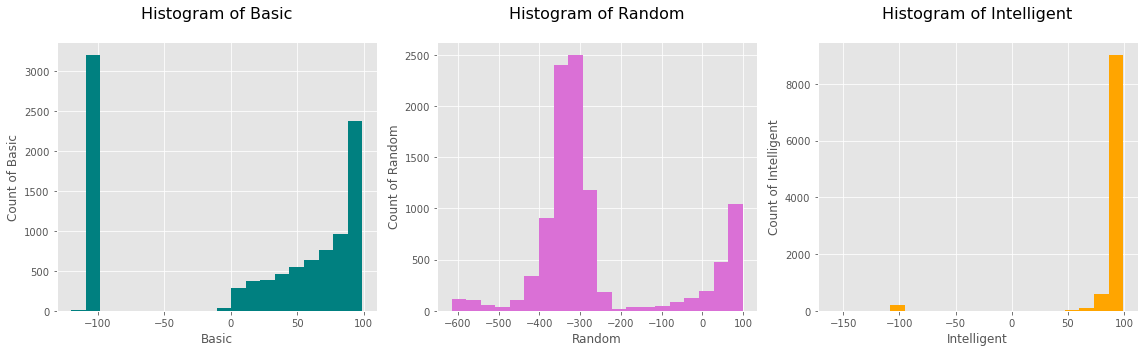

In [1044]:
fig, ax = plt.subplots(1, 3, figsize=(16,5))

feature_cols = [runs_df.basic, runs_df.random, runs_df.intell]
names = ['Basic', 'Random', 'Intelligent']
colors = ['teal', 'orchid', 'orange']

for i in range(len(feature_cols)):
    ax[i].hist(feature_cols[i], color= colors[i], bins=20)
    ax[i].set_xlabel(names[i])
    ax[i].set_ylabel("Count of " + names[i])
    ax[i].set_title("Histogram of "+ names[i] +"\n", fontsize = (16))

plt.tight_layout()
plt.show()